In [1]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

raw_model = 'aiknowyou/mt5-base-it-paraphraser'

# Model and Tokenizer definition #
model = T5ForConditionalGeneration.from_pretrained(raw_model)
tokenizer = T5Tokenizer.from_pretrained(raw_model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_size = 10000

def paraphrase(text, beams=100, grams=10, num_return_sequences=5):
    x = tokenizer(text, return_tensors='pt', padding=True).to(model.device)
    max_size = int(x.input_ids.shape[1] * 1.5 + 10)
    out = model.generate(**x, encoder_no_repeat_ngram_size=grams, num_beams=beams, num_return_sequences=num_return_sequences, max_length=max_size)
    return tokenizer.batch_decode(out, skip_special_tokens=True)
  
sentence = "Due amici si incontrano al bar per discutere del modo migliore di generare parafrasi."
print(paraphrase(sentence))

Downloading:   0%|          | 0.00/977M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/765k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/354 [00:00<?, ?B/s]

['Due amici stanno discutendo del modo migliore per generare parafrasi.', 'Due amici si incontrano a un bar per discutere del modo migliore per generare parafrasi.', 'Due amici si incontrano al bar per parlare del modo migliore per generare parafrasi.', 'Due amici sono seduti al bar per discutere del modo migliore per generare parafrasi.', 'Due amici si incontrano in un bar per discutere del modo migliore per generare parafrasi.']


In [12]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import re

In [ ]:
paraphrase(sentence, num_return_sequences=50)

['Due amici stanno discutendo del modo migliore per generare parafrasi.',
 'Due amici si incontrano a un bar per discutere del modo migliore per generare parafrasi.',
 'Due amici si incontrano al bar per parlare del modo migliore per generare parafrasi.',
 'Due amici sono seduti al bar per discutere del modo migliore per generare parafrasi.',
 'Due amici si incontrano in un bar per discutere del modo migliore per generare parafrasi.',
 'Due amici si incontrano al bar di un bar per discutere del modo migliore per generare parafrasi.',
 'Due amici si incontrano per discutere del modo migliore per generare parafrasi.',
 'Due amici stanno discutendo il modo migliore per generare parafrasi.',
 'Un gruppo di amici si incontra al bar per discutere del modo migliore per generare parafrasi.',
 'Un uomo e una donna stanno discutendo del modo migliore per generare parafrasi.',
 'Due amici si incontrano al bar e discutono del modo migliore per generare parafrasi.',
 'Un gruppo di persone si incont

In [ ]:
paraphrase(sentence, beams=50, grams=5, num_return_sequences=50)

['Due amici stanno discutendo del modo migliore per generare Parafrasi.',
 'Un uomo e una donna stanno discutendo del modo migliore per generare Parafrasi.',
 'Due amici stanno discutendo il modo migliore per generare Parafrasi.',
 'Un uomo e una donna stanno discutendo il modo migliore per generare Parafrasi.',
 'Due amici stanno discutendo di un modo migliore per generare Parafrasi.',
 'Un uomo e una donna si incontrano a un bar per discutere il modo migliore per generare Parafrasi.',
 'Un uomo e una donna si incontrano a un bar per discutere dei modi migliori per generare Parafrasi.',
 'Due amici stanno discutendo dei modi migliori per generare Parafrasi.',
 'Due uomini stanno discutendo del modo migliore per generare Parafrasi.',
 'Un uomo e un ragazzo stanno discutendo del modo migliore per generare Parafrasi.',
 'Un uomo e una donna stanno discutendo di un modo migliore per generare Parafrasi.',
 'Due amici stanno discutendo sul modo migliore per generare Parafrasi.',
 'Un uomo e

In [2]:
import pandas as pd
df = pd.read_csv("RepML_original/data/processed/splitted_full/unbalanced_train.csv", sep=",")
df.describe()

,Domanda,Testo,Stralcio,Repertorio
count,3,9205,20981,20981
unique,1,9182,20930,23
top,A cosa serve questo testo per il perseguimento...,Scusate una domanda perché forse non ci arrivo...,"Covid,",sancire
freq,3,2,4,3360


In [6]:
def twitter_preprocess(text:str) -> str:
    """
    - It takes a string as input
    - It returns a string as output
    - It does the following:
        - Normalizes terms like url, email, percent, money, phone, user, time, date, number
        - Annotates hashtags
        - Fixes HTML tokens
        - Performs word segmentation on hashtags
        - Tokenizes the string
        - Replaces tokens extracted from the text with other expressions
        - Removes non-alphanumeric characters
        - Removes extra whitespaces
        - Removes repeated characters
        - Removes leading and trailing whitespaces
    
    :param text: The text to be processed
    :type text: str
    :return: A string with the preprocessed text.
    """
    text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag"},
    fix_html=True,  # fix HTML tokens
    
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
    )

    text = str(" ".join(text_processor.pre_process_doc(text)))
    text = re.sub(r"[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]", ' ', text)
    text = re.sub(r"\s+", ' ', text)
    text = re.sub(r'(\w)\1{2,}',r'\1\1', text)
    text = re.sub ( r'^\s' , '' , text )
    text = re.sub ( r'\s$' , '' , text )

    return text

In [19]:
n = 1000
gb = df.groupby('Repertorio')

new_samples = dict()

for x in gb.groups:
    print(x)
    class_df = gb.get_group(x)
    need_to_generate = n - len(class_df)
    print(f"Need to generate: {need_to_generate}")
    new_samples[x] = []
    if need_to_generate <= 0:
        pass

    else:
        new_per_example = round(need_to_generate / len(class_df))
        print(f"New examples per sample to generate: {new_per_example}")
        min_rounds = new_per_example * len(class_df)
        full_rounds = need_to_generate - min_rounds
        full_count = 0
        for stralcio in class_df.Stralcio:
            if full_count < full_rounds:
                new_example = paraphrase(stralcio, beams=50, grams=15, num_return_sequences=(new_per_example + 1))
                full_count += 1
                new_samples[x].extend(new_example)
            elif new_per_example != 0:
                new_example = paraphrase(stralcio, beams=50, grams=15, num_return_sequences=(new_per_example))
                new_samples[x].extend(new_example)
            else:
                pass

anticipazione
Need to generate: 968
New examples per sample to generate: 30
causa
Need to generate: 716
New examples per sample to generate: 3


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 154982400 bytes.

In [ ]:
new_samples

In [ ]:
df.Repertorio.value_counts()

sancire                     3360
descrizione                 2919
commento                    2618
giudizio                    1655
valutazione                 1274
prescrizione                1148
contrapposizione             846
specificazione               835
opinione                     801
non risposta                 696
previsione                   696
ridimensionamento            644
generalizzazione             632
implicazione                 423
dichiarazione di intenti     383
conferma                     381
deresponsabilizzazione       380
possibilità                  370
causa                        284
giustificazione              262
considerazione               188
proposta                     154
anticipazione                 32
Name: Repertorio, dtype: int64

In [9]:
text = df[df.Repertorio == "anticipazione"].Stralcio[0]

In [13]:
twitter_preprocess(text)

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...


'c è innanzitutto un orizzonte di breve periodo queste settimane i prossimi mesi nel quale l imperativo categorico è rappresentato dalla ripartenza'

In [15]:
text

'C’è, innanzitutto, un orizzonte di breve periodo (queste settimane, i prossimi mesi) nel quale l’imperativo categorico è rappresentato dalla «ripartenza»'

In [16]:
new_text = "c è innanzitutto un orizzonte di breve periodo queste settimane i prossimi mesi nel quale l imperativo categorico è rappresentato dalla ripartenza"

In [ ]:
#sentence = df[df.Repertorio == "anticipazione"].Stralcio[1]
sentence = 'Sulla Mostra del cinema probabilmente non ci saranno tutte le produzioni che siamo abituati a vedere perché si sono fermate le lavorazioni ed anteprime dei film".'

In [17]:
paraphrase(new_text, beams=50, grams=10, num_return_sequences=5)

["L'orizzonte di breve periodo delle settimane i prossimi mesi è rappresentato dalla ripartenza.",
 "C'è un orizzonte breve questa settimana i prossimi mesi nel quale c'è un orizzonte di breve periodo nel quale c'è un imperativo categorico rappresentato dalla ripartenza.",
 "C'è un orizzonte breve questa settimana i prossimi mesi nel quale c'è un orizzonte di breve periodo nel quale c'è l imperativo categorico della ripartenza.",
 "C'è un orizzonte breve questa settimana i prossimi mesi nel quale c'è un orizzonte di breve periodo nel quale c è un imperativo categorico rappresentato dalla ripartenza.",
 "C'è un orizzonte breve questo periodo i prossimi mesi nel quale c'è un orizzonte di breve periodo nel quale c'è l imperativo categorico della ripartenza."]

In [18]:
paraphrase(text, beams=50, grams=10, num_return_sequences=5)

["C'è un orizzonte di breve periodo nel quale l'imperativo categorico è rappresentato dalla ripartenza.",
 "Questo è un orizzonte di breve periodo nel quale l'imperativo categorico è rappresentato dalla ripartenza.",
 "C'è un orizzonte di breve periodo, questa settimana, i prossimi mesi, nel quale l'imperativo categorico è rappresentato dalla ripartenza.",
 'C\'è un orizzonte di breve periodo nel quale l\'imperativo categorico è rappresentato dalla "ripartenza".',
 "C'è anche un orizzonte di breve periodo nel quale l'imperativo categorico è rappresentato dalla ripartenza."]

In [1]:
# representation 1
import numpy as np
A = np.array([1, 0, 0, 0])
B = np.array([0, 1, 0, 0])
C = np.array([0, 0, 1, 0])
D = np.array([0, 0, 0, 1])
E = A + D
F = A + C
G = D + B
H = C + D
I = B + A
K = A + A
L = C + A
M = I + K + F + D
N = G + H
O = I + K
P = F + G + I
Q = E + F

In [24]:
# representation 2
import numpy as np
A = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
B = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
C = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
D = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
E = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
F = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
G = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
H = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
I = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
K = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
L = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
M = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
N = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
O = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
P = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
Q = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [3]:
# without A and B everywhere
rep = dict()
rep['SR'] = A
rep['DS'] = B
rep['SP'] = C
rep['PO'] = D
rep['OP'] = E + F
rep['RO'] = G + H
rep['CA'] = I + K
rep['CF'] = C + A
rep['NR'] = A + E + I
rep['CT'] = L + F + E + H
rep['IM'] = M
rep['GZ'] = Q + A + L
rep['PV'] = I + K + H + L
rep['GI'] = Q + O + D
rep['CM'] = Q + A + I
rep['GN'] = L + D + E + G
rep['VA'] = F + G + I
rep['DI'] = N + O + E + L
rep['PR'] = N + C + D
rep['DR'] = F + Q + O + D
rep['PZ'] = F + G + M
# rep['RI'] = G + F + L + D + E + G+ N
rep['RI'] = G + F + L + D + E + N
rep['CO'] = G + E + N + I
rep['AN'] = G + B + P + N

In [25]:
# considering A and B everywhere 
rep = dict()
rep['sancire'] = A
rep['descrizione'] = B
rep['specificazione'] = C
rep['possibilità'] = D
rep['opinione'] = E + F
# rep['RO'] = G + H 
rep['causa'] = I + K
rep['conferma'] = C + A
rep['non risposta'] = A + E + I
rep['contrapposizione'] = L + F + E + H
rep['implicazione'] = M
rep['giudizio'] = Q + A + L
rep['previsione'] = I + K + H + L
rep['giustificazione'] = Q + O + D
rep['commento'] = Q + A + I
rep['generalizzazione'] = L + D + E + G
rep['valutazione'] = F + G + I
rep['dichiarazione di intenti'] = N + O + E + L
rep['proposta'] = N + C + D
rep['deresponsabilizzazione'] = F + Q + O + D 
rep['prescrizione'] = F + G + M
#rep['ridimensionamento'] = G + F + L + D + E + G + N
rep['ridimensionamento'] = G + F + L + D + E + N
rep['considerazione'] = G + E + N + I
rep['anticipazione'] = G + B + P + N

In [26]:
rep

{'sancire': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'descrizione': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'specificazione': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'possibilità': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'opinione': array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'causa': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]),
 'conferma': array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'non risposta': array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'contrapposizione': array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]),
 'implicazione': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'giudizio': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]),
 'previsione': array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]),
 'giustificazione': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]),
 'commento': array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

In [4]:
rep = dict()
rep['sancire'] = A
rep['discrizione'] = B
rep['specificazione'] = C
rep['possibilità'] = D
rep['opinione'] = E + F
rep['RO'] = G + H
rep['causa'] = I + K
rep['conferma'] = C + A
rep['non risposta'] = A + E + I
rep['contrapposizione'] = L + F + E + H
rep['implicazione'] = M + [0, 2, 0, 0]
rep['giudizio'] = Q + A + L
rep['previsione'] = I + K + H + L
rep['giustificazione'] = Q + O + D
rep['commento'] = Q + A + I
rep['generalizzazione'] = L + D + E + L
rep['valutazione'] = F + G + I
rep['dichiarazione di intenti'] = N + O + E + L
rep['proposta'] = N + C + D
rep['deresponsabilizzazione'] = F + Q + O + D
rep['prescrizione'] = F + G + M
rep['ridimensionamento'] = G + F + L + D + E + G + N
rep['considerazione'] = G + E + N + I
rep['anticipazione'] = G + B + P + N
rep

{'sancire': array([1, 0, 0, 0]),
 'discrizione': array([0, 1, 0, 0]),
 'specificazione': array([0, 0, 1, 0]),
 'possibilità': array([0, 0, 0, 1]),
 'opinione': array([2, 0, 1, 1]),
 'RO': array([0, 1, 1, 2]),
 'causa': array([3, 1, 0, 0]),
 'conferma': array([1, 0, 1, 0]),
 'non risposta': array([3, 1, 0, 1]),
 'contrapposizione': array([3, 0, 3, 2]),
 'implicazione': array([4, 3, 1, 1]),
 'giudizio': array([4, 0, 2, 1]),
 'previsione': array([4, 1, 2, 1]),
 'giustificazione': array([5, 1, 1, 2]),
 'commento': array([4, 1, 1, 1]),
 'generalizzazione': array([3, 0, 2, 2]),
 'valutazione': array([2, 2, 1, 1]),
 'dichiarazione di intenti': array([5, 2, 2, 3]),
 'proposta': array([0, 1, 2, 3]),
 'deresponsabilizzazione': array([6, 1, 2, 2]),
 'prescrizione': array([5, 2, 2, 2]),
 'ridimensionamento': array([3, 3, 3, 6]),
 'considerazione': array([2, 3, 1, 4]),
 'anticipazione': array([2, 5, 2, 4])}

In [19]:
LABELS = {
    'anticipazione': 0,
    'causa': 1,
    'commento': 2,
    'conferma': 3,
    'considerazione': 4,
    'contrapposizione': 5,
    'deresponsabilizzazione': 6,
    'descrizione': 7,
    'dichiarazione di intenti':8,
    'generalizzazione': 9,
    'giudizio': 10,
    'giustificazione': 11,
    'implicazione': 12,
    'non risposta': 13,
    'opinione': 14,
    'possibilità': 15,
    'prescrizione': 16,
    'previsione': 17,
    'proposta': 18,
    'ridimensionamento': 19,
    'sancire': 20,
    'specificazione': 21,
    'valutazione': 22
}

In [6]:
rep_scaled = dict()
for r in rep:
    rep_scaled[r] = rep[r] / np.linalg.norm(rep[r])
rep_scaled

{'sancire': array([1., 0., 0., 0.]),
 'discrizione': array([0., 1., 0., 0.]),
 'specificazione': array([0., 0., 1., 0.]),
 'possibilità': array([0., 0., 0., 1.]),
 'opinione': array([0.81649658, 0.        , 0.40824829, 0.40824829]),
 'RO': array([0.        , 0.40824829, 0.40824829, 0.81649658]),
 'causa': array([0.9486833 , 0.31622777, 0.        , 0.        ]),
 'conferma': array([0.70710678, 0.        , 0.70710678, 0.        ]),
 'non risposta': array([0.90453403, 0.30151134, 0.        , 0.30151134]),
 'contrapposizione': array([0.63960215, 0.        , 0.63960215, 0.42640143]),
 'implicazione': array([0.76980036, 0.57735027, 0.19245009, 0.19245009]),
 'giudizio': array([0.87287156, 0.        , 0.43643578, 0.21821789]),
 'previsione': array([0.85280287, 0.21320072, 0.42640143, 0.21320072]),
 'giustificazione': array([0.89802651, 0.1796053 , 0.1796053 , 0.3592106 ]),
 'commento': array([0.91766294, 0.22941573, 0.22941573, 0.22941573]),
 'generalizzazione': array([0.72760688, 0.        ,

In [43]:
rep_num = dict()
for r in rep:
    i = LABELS[r]
    rep_num[i] = rep[r]
rep_num

{20: array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 7: array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 21: array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 15: array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 14: array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 1: array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]),
 3: array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 13: array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 5: array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]),
 12: array([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0]),
 10: array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]),
 17: array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0]),
 11: array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]),
 2: array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]),
 9: array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]),
 22: array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]),
 8: array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0]),
 18: array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),

In [44]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    return dot(a, b)/(norm(a)*norm(b))

In [45]:
M = np.zeros((23,23))
for i in range(len(M)):
    for j in range(i, len(M)):
        a = cos_sim(rep_num[i], rep_num[j])
        M[i][j] = a
        M[j][i] = a
M

array([[1.        , 0.31622777, 0.25819889, 0.        , 0.67082039,
        0.2236068 , 0.2236068 , 0.4472136 , 0.2236068 , 0.2236068 ,
        0.        , 0.        , 0.4472136 , 0.25819889, 0.31622777,
        0.        , 0.63245553, 0.2236068 , 0.25819889, 0.54772256,
        0.        , 0.        , 0.77459667],
       [0.31622777, 1.        , 0.40824829, 0.        , 0.35355339,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.70710678, 0.40824829, 0.        ,
        0.        , 0.5       , 0.70710678, 0.        , 0.        ,
        0.        , 0.        , 0.40824829],
       [0.25819889, 0.40824829, 1.        , 0.40824829, 0.28867513,
        0.        , 0.28867513, 0.        , 0.        , 0.        ,
        0.66666667, 0.33333333, 0.28867513, 0.66666667, 0.        ,
        0.        , 0.20412415, 0.28867513, 0.        , 0.        ,
        0.57735027, 0.        , 0.33333333],
       [0.        , 0.        , 0.40824829, 1.   

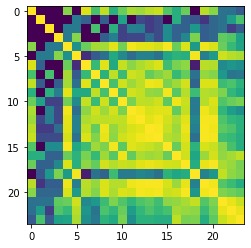

In [19]:
# 4 vector representation
import matplotlib.pyplot as plt

plt.imshow(M, interpolation='nearest')
plt.show()

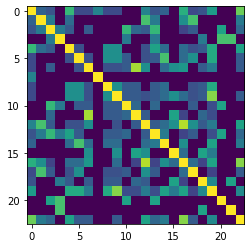

In [46]:
# 16 vector represenation
import matplotlib.pyplot as plt

plt.imshow(M, interpolation='nearest')
plt.show()

In [25]:
a = np.array([0.9, 0.05, 0.05, 0.05])
for r in rep_scaled:
    print(cos_sim(a, rep_scaled[r]))

0.995402274496796
0.055300126360933115
0.055300126360933115
0.055300126360933115
0.8578949178728889
0.0903047281971462
0.9618089480761699
0.7429587926554864
0.9337224654466897
0.6956115667276962
0.9515039304171198
0.9050607678199956
0.8960420181577102
0.9336264143343753
0.9515039304171198
0.7779105412691522
0.6994974167826691
0.8277004908294398
0.08867748269482188
0.9315331408622212
0.8727633380731867
0.4598326285817827
0.444240524064614
0.371300848423408


In [40]:
import pandas as pd
df = pd.DataFrame([[k, v[0], v[1]] for k, v in rep_2.items()], columns=['rep', 'A', 'B'])

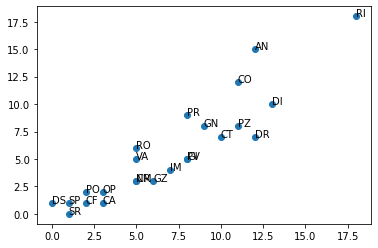

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(df.A, df.B)

for i, txt in enumerate(df.rep):
    plt.annotate(txt, (df.A[i], df.B[i]))

# Check the distribution of 16 new classes

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("RepML_original/data/processed/clean/hyperion.csv", sep=",")
df.describe()

,Domanda,Testo,Stralcio,Repertorio
count,4,15332,35148,35148
unique,1,15245,34918,23
top,A cosa serve questo testo per il perseguimento...,In conferenza stampa per tutti gli aggiornamen...,Grazie,sancire
freq,4,3,20,5627


In [3]:
# representation 2
import numpy as np
A = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
B = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
C = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
D = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
E = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
F = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
G = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
H = np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
I = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
K = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
L = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
M = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
N = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
O = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
#P = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
Q = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
rep = dict()
rep['sancire'] = A
rep['descrizione'] = B
rep['specificazione'] = C
rep['possibilità'] = D
rep['opinione'] = E + F
# rep['RO'] = G + H 
rep['causa'] = I + K
rep['conferma'] = C + A
rep['non risposta'] = A + E + I
rep['contrapposizione'] = L + F + E + H
rep['implicazione'] = M
rep['giudizio'] = Q + A + L
rep['previsione'] = I + K + H + L
rep['giustificazione'] = Q + O + D
rep['commento'] = Q + A + I
rep['generalizzazione'] = L + D + E + G
rep['valutazione'] = F + G + I
rep['dichiarazione di intenti'] = N + O + E + L
rep['proposta'] = N + C + D
rep['deresponsabilizzazione'] = F + Q + O + D
rep['prescrizione'] = F + G + M
#rep['ridimensionamento'] = G + F + L + D + E + G + N
rep['ridimensionamento'] = G + F + L + D + E + N
rep['considerazione'] = G + E + N + I
rep['anticipazione'] = G + B + F + I + N

In [4]:
array = np.stack(df.Repertorio.apply(lambda x: rep[x]).values)

In [5]:
new_col = pd.DataFrame(array, columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 
                                       'O', 'Q'])
new_col.describe()

,A,B,C,D,E,F,G,H,I,K,L,M,N,O,Q
count,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000,35148.000000
mean,0.415273,0.140406,0.065182,0.117162,0.200353,0.244452,0.187095,0.073489,0.275891,0.046745,0.232104,0.074713,0.067315,0.048964,0.234579
std,0.492776,0.347413,0.246849,0.321617,0.400270,0.429768,0.389993,0.260942,0.446968,0.211096,0.422181,0.262931,0.250571,0.215797,0.423742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
np.array((1 - new_col.mean()) /  new_col.mean())

array([ 1.408057  ,  6.12218845, 14.34177215,  7.53521127,  3.99119568,
        3.09078212,  4.34489051, 12.60743322,  2.62462617, 20.39257456,
        3.30840892, 12.38461538, 13.85545224, 19.42300988,  3.26294724])

In [9]:
np.array(1 / new_col.mean())

array([ 2.408057  ,  7.12218845, 15.34177215,  8.53521127,  4.99119568,
        4.09078212,  5.34489051, 13.60743322,  3.62462617, 21.39257456,
        4.30840892, 13.38461538, 14.85545224, 20.42300988,  4.26294724])

In [4]:
A = np.array([1, 0, 0])
B = np.array([0, 1, 0])
C = np.array([0, 0, 1])

rep = dict()
rep['sancire'] = A
rep['descrizione'] = B
rep['specificazione'] = C
rep['possibilità'] = C
rep['opinione'] = A
# rep['RO'] = G + H 
rep['causa'] = A
rep['conferma'] = C
rep['non risposta'] = A
rep['contrapposizione'] = A
rep['implicazione'] = C
rep['giudizio'] = A
rep['previsione'] = A
rep['giustificazione'] = A
rep['commento'] = A
rep['generalizzazione'] = A
rep['valutazione'] = C
rep['dichiarazione di intenti'] = C
rep['proposta'] = B
rep['deresponsabilizzazione'] = A
rep['prescrizione'] = C
#rep['ridimensionamento'] = G + F + L + D + E + G + N
rep['ridimensionamento'] = C
rep['considerazione'] = B
rep['anticipazione'] = B

In [6]:
array = np.stack(df.Repertorio.apply(lambda x: rep[x]).values)
df = pd.DataFrame(array, columns=['A', 'B', 'C'])
df.describe()

,A,B,C
count,35148.000000,35148.000000,35148.000000
mean,0.583248,0.156567,0.260186
std,0.493028,0.363397,0.438742
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


In [7]:
np.array((1 - df.mean()) /  df.mean())

array([0.71453659, 5.3870616 , 2.8434117 ])